# Report figure generator

### The aim of this notebook is to generate images to the report of the thesis

In [40]:
from pathlib import Path
import dask.array as da
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage.transform import resize
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
import torch
import sys
project_root = Path().resolve().parent
sys.path.append(str(project_root))
from supertrab.metrics_utils import get_mask_ormir, get_mask_otsu


In [41]:
# --- Define paths ---
zarr_root = Path("/usr/terminus/data-xrm-01/stamplab/RESTORE/supertrab.zarr")
group_name = "2019_L"
dataset_name = "image_split/part_2_split/part_14"
dataset_name_sr = "sr_volume_256_6/part_2_split/part_14"

# --- Load Dask arrays ---
img = da.from_zarr(zarr_root / group_name / dataset_name)
img_sr = da.from_zarr(zarr_root / group_name / dataset_name_sr)

# --- Inspect shape ---
print(f"Image shape: {img.shape}")     # Expect (N, 1, H, W)
print(f"SR image shape: {img_sr.shape}")


Image shape: (177, 4608, 4608)
SR image shape: (177, 4608, 4608)


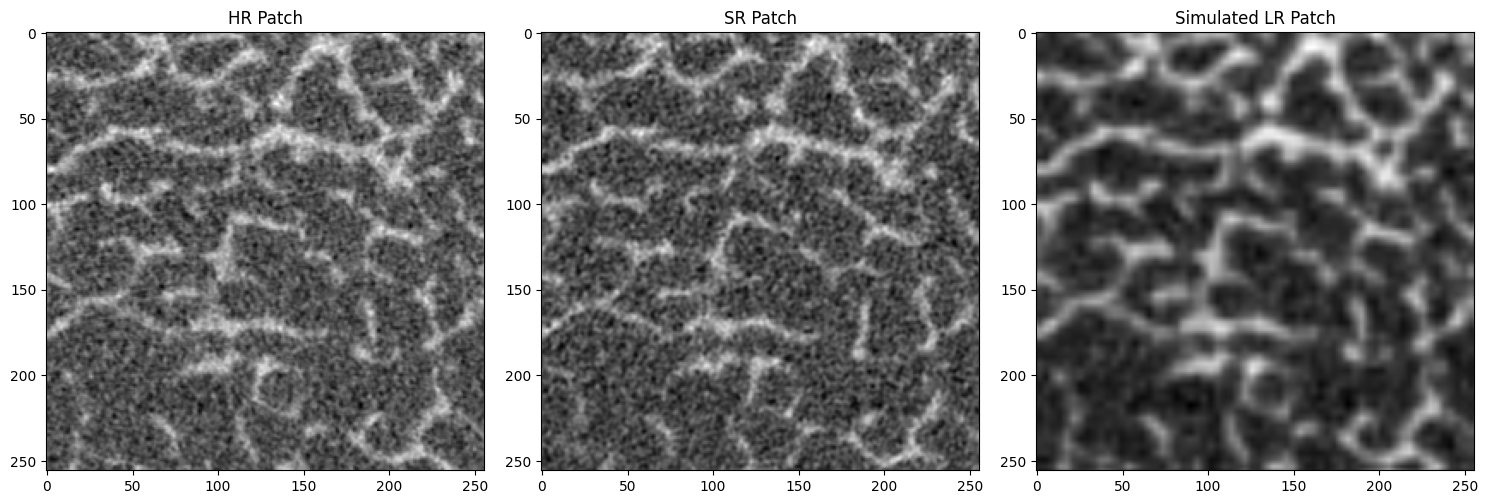

In [42]:

# Define patch parameters
z, y, x = 0, 1280, 2304  # starting coordinates (adjust these)
patch_size = 256

# Slice patches (2D slice from Z dimension)
patch_hr = img[z, y:y+patch_size, x:x+patch_size].compute()
patch_sr = img_sr[z, y:y+patch_size, x:x+patch_size].compute()

#generate LR
blurred = gaussian_filter(patch_hr, sigma=1.3)
downsample_factor = 4
small = resize(blurred, (patch_size // downsample_factor, patch_size // downsample_factor), order=1, mode='reflect', anti_aliasing=True)
patch_lr = resize(small, (patch_size, patch_size), order=1, mode='reflect', anti_aliasing=True)


# Show the patches
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(patch_hr, cmap="gray")
axes[0].set_title("HR Patch")

axes[1].imshow(patch_sr, cmap="gray")
axes[1].set_title("SR Patch")

axes[2].imshow(patch_lr, cmap="gray")
axes[2].set_title("Simulated LR Patch")

plt.tight_layout()
plt.show()

/tmp/ipykernel_596293/484623517.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


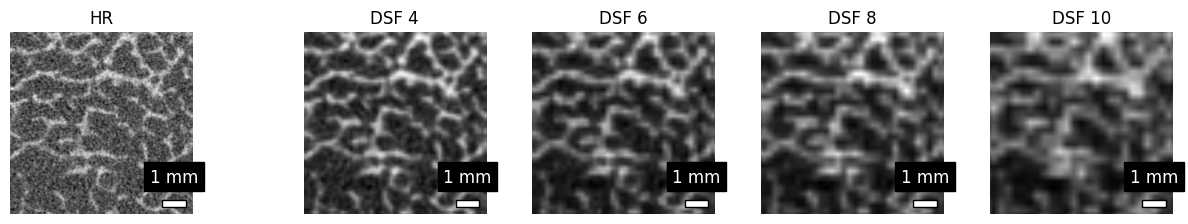

In [46]:
ds_factors = [4, 6, 8, 10]
patch_lrs = []
for dsf in ds_factors:
    blurred = gaussian_filter(patch_hr, sigma=1.3)
    small = resize(blurred, (patch_size // dsf, patch_size // dsf), order=1, mode='reflect', anti_aliasing=True)
    restored = resize(small, (patch_size, patch_size), order=1, mode='reflect', anti_aliasing=True)
    patch_lrs.append(restored)

# --- Plot settings ---
patches_all = [patch_hr] + patch_lrs
titles = ["HR"] + [f"DSF {dsf}" for dsf in ds_factors]

## --- Create GridSpec with custom widths ---
fig = plt.figure(figsize=(15, 5))
gs = GridSpec(1, len(patches_all) + 1, width_ratios=[1, 0.1, 1, 1, 1, 1], wspace=0.3)

# --- Voxel size and scale bar ---
voxel_size_um = 30.3
scale_bar_length_um = 1000  # 1 mm
scale_bar_voxels = int(scale_bar_length_um / voxel_size_um)

titles = ["HR"] + [f"DSF {dsf}" for dsf in ds_factors]

for i, (patch, title) in enumerate(zip(patches_all, titles)):
    # Skip the second column (extra space)
    ax = fig.add_subplot(gs[i if i == 0 else i + 1])
    ax.imshow(patch, cmap="gray")
    ax.set_title(title)
    ax.axis("off")

    # Add 1 mm scale bar
    bar_height = 10  # increase from 5
    bar_color = "white"
    bar_edgecolor = "black"
    x_bar = patch.shape[1] - scale_bar_voxels - 10
    y_bar = patch.shape[0] - bar_height - 10
    rect = patches.Rectangle(
        (x_bar, y_bar),
        scale_bar_voxels,
        bar_height,
        linewidth=1, edgecolor=bar_edgecolor, facecolor=bar_color
    )
    ax.add_patch(rect)
    ax.text(x_bar + scale_bar_voxels / 2, y_bar - 20, "1 mm",
            color="white", ha="center", va="bottom", fontsize=12,
            backgroundcolor="black")

plt.tight_layout()
plt.show()

# Get image of SR 3D patches

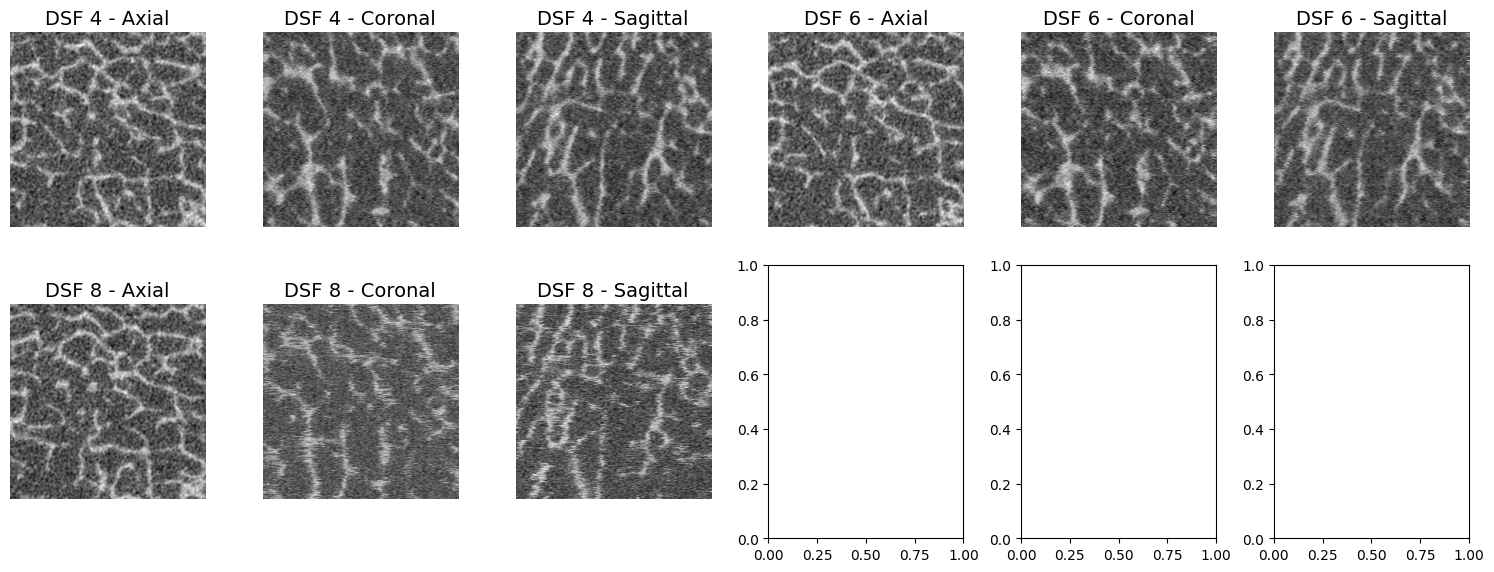

In [18]:
ds_factors = [4, 6, 8 ]#, 10]
z, y, x = 128, 1280, 2304
half = patch_size // 2

# --- Plot layout: 2 DSFs per row, 3 slices per DSF ---
cols_per_dsf = 3
dsfs_per_row = 2
n_rows = (len(ds_factors) + 1) // dsfs_per_row  # ceil
fig, axes = plt.subplots(n_rows, dsfs_per_row * cols_per_dsf, figsize=(15, 3 * n_rows))

# If axes is 1D, wrap it
if n_rows == 1:
    axes = [axes]

for idx, dsf in enumerate(ds_factors):
    # Load and stack part_13 and part_14
    if dsf == 4:
        path_13 = f"sr_volume_256_{dsf}_200ep/part_2_split/part_13"
        path_14 = f"sr_volume_256_{dsf}_200ep/part_2_split/part_14"
    else:
        path_13 = f"sr_volume_256_{dsf}/part_2_split/part_13"
        path_14 = f"sr_volume_256_{dsf}/part_2_split/part_14"
    vol_13 = da.from_zarr(zarr_root / group_name / path_13)
    vol_14 = da.from_zarr(zarr_root / group_name / path_14)
    vol = da.concatenate([vol_13, vol_14], axis=0)

    # Extract patch
    patch = vol[z - half:z + half, y:y + patch_size, x:x + patch_size].compute()

    # Get orthogonal slices
    axial = patch[patch_size // 2, :, :]
    coronal = patch[:, patch_size // 2, :]
    sagittal = patch[:, :, patch_size // 2]

    row = idx // dsfs_per_row
    col_start = (idx % dsfs_per_row) * cols_per_dsf

    for j, (slice_img, label) in enumerate(zip([axial, coronal, sagittal], ["Axial", "Coronal", "Sagittal"])):
        ax = axes[row][col_start + j] if n_rows > 1 else axes[col_start + j]
        ax.imshow(slice_img, cmap="gray")
        ax.set_title(f"DSF {dsf} - {label}", fontsize=14)
        ax.axis("off")
        ax.set_aspect("equal", adjustable="box")

plt.tight_layout()
plt.show()


### Show segmentation results

In [37]:
# --- Load HR volume (stack part_13 and part_14) ---
hr_path_13 = "image_split/part_2_split/part_13"
hr_path_14 = "image_split/part_2_split/part_14"
hr_vol = da.concatenate([
    da.from_zarr(zarr_root / group_name / hr_path_13),
    da.from_zarr(zarr_root / group_name / hr_path_14)
], axis=0)

# --- Load SR volume for DSF = 8 ---
dsf = 8
sr_path_13 = f"sr_volume_256_{dsf}/part_2_split/part_13"
sr_path_14 = f"sr_volume_256_{dsf}/part_2_split/part_14"
sr_vol = da.concatenate([
    da.from_zarr(zarr_root / group_name / sr_path_13),
    da.from_zarr(zarr_root / group_name / sr_path_14)
], axis=0)

# --- Extract 256³ patch from each ---
patch_hr = hr_vol[z - half:z + half, y:y + patch_size, x:x + patch_size].compute()
patch_sr = sr_vol[z - half:z + half, y:y + patch_size, x:x + patch_size].compute()

# --- Simulate LR patch from HR (blur + downsample + upsample) ---
sigma = 1.3
blurred = gaussian_filter(patch_hr, sigma=sigma)
downsampled = resize(blurred, (patch_size // dsf, patch_size // dsf, patch_size // dsf),
                     order=1, mode='reflect', anti_aliasing=True)
patch_lr = resize(downsampled, (patch_size, patch_size, patch_size),
                  order=1, mode='reflect', anti_aliasing=True)

# --- Shapes check ---
print("HR patch shape:", patch_hr.shape)
print("LR patch shape:", patch_lr.shape)
print("SR patch shape:", patch_sr.shape)

HR patch shape: (256, 256, 256)
LR patch shape: (256, 256, 256)
SR patch shape: (256, 256, 256)


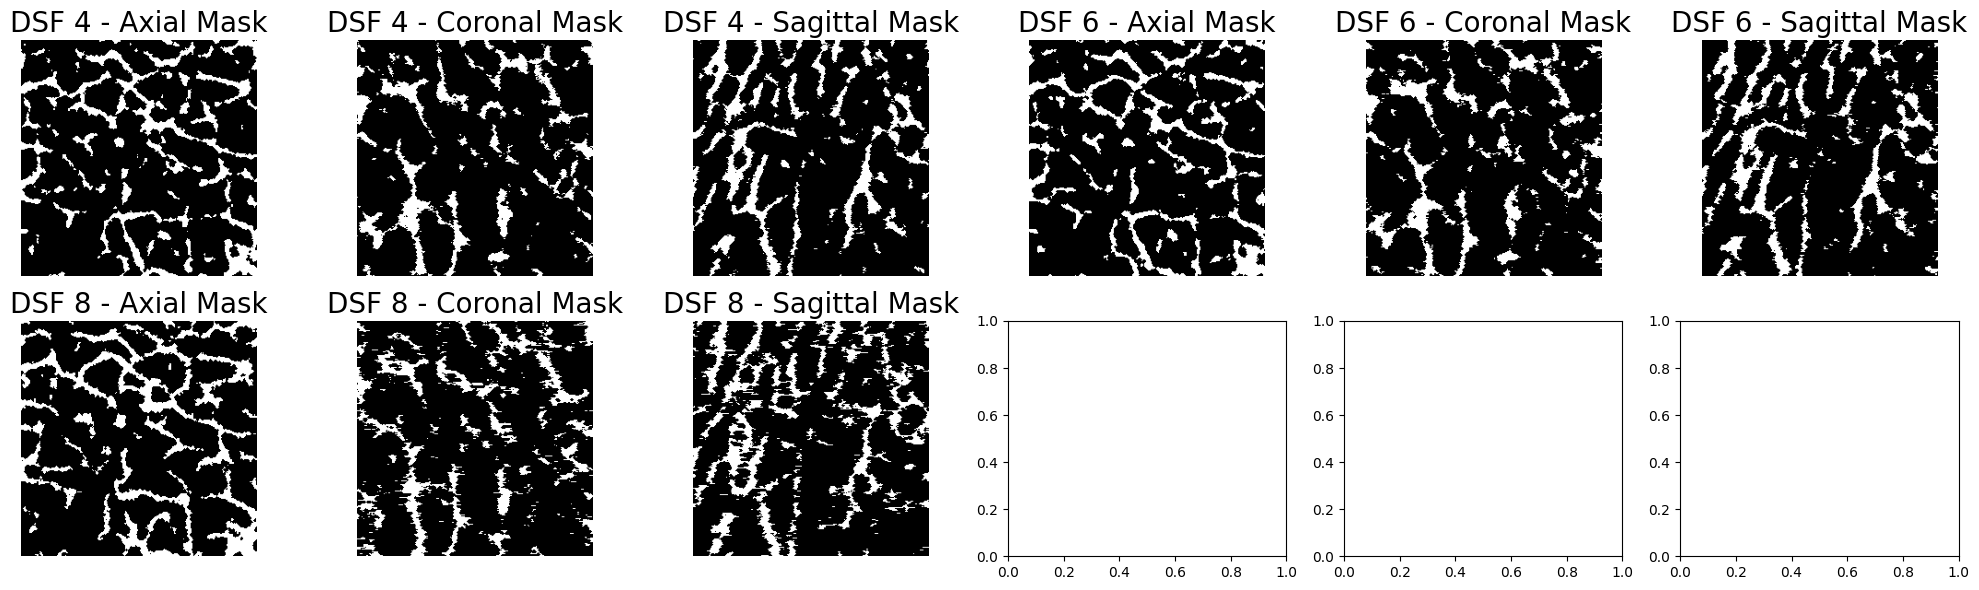

In [20]:
ds_factors = [4, 6, 8]
z, y, x = 128, 1280, 2304
half = patch_size // 2

# Plot layout: 2 DSFs per row, 3 slices per DSF
cols_per_dsf = 3
dsfs_per_row = 2
n_rows = (len(ds_factors) + 1) // dsfs_per_row
fig, axes = plt.subplots(n_rows, dsfs_per_row * cols_per_dsf, figsize=(20, 3 * n_rows))

# Wrap axes if single row
if n_rows == 1:
    axes = [axes]

for idx, dsf in enumerate(ds_factors):
    # Load volume
    if dsf == 4:
        path_13 = f"sr_volume_256_{dsf}_200ep/part_2_split/part_13"
        path_14 = f"sr_volume_256_{dsf}_200ep/part_2_split/part_14"
    else:
        path_13 = f"sr_volume_256_{dsf}/part_2_split/part_13"
        path_14 = f"sr_volume_256_{dsf}/part_2_split/part_14"

    vol_13 = da.from_zarr(zarr_root / group_name / path_13)
    vol_14 = da.from_zarr(zarr_root / group_name / path_14)
    vol = da.concatenate([vol_13, vol_14], axis=0)

    # Extract patch
    patch = vol[z - half:z + half, y:y + patch_size, x:x + patch_size].compute()

    # Convert to tensor (normalize if needed)
    patch_tensor = torch.from_numpy(patch).unsqueeze(0) 

    # Get mask: returns shape (D, H, W)
    mask = get_mask_ormir(patch_tensor)

    # Extract slices
    axial = mask[patch_size // 2, :, :].numpy()
    coronal = mask[:, patch_size // 2, :].numpy()
    sagittal = mask[:, :, patch_size // 2].numpy()

    row = idx // dsfs_per_row
    col_start = (idx % dsfs_per_row) * cols_per_dsf

    for j, (slice_mask, label) in enumerate(zip([axial, coronal, sagittal], ["Axial", "Coronal", "Sagittal"])):
        ax = axes[row][col_start + j] if n_rows > 1 else axes[col_start + j]
        ax.imshow(slice_mask, cmap="gray")
        ax.set_title(f"DSF {dsf} - {label} Mask", fontsize=20)
        ax.axis("off")
        ax.set_aspect("equal", adjustable="box")

plt.tight_layout()
plt.show()


In [21]:
import dask.array as da
from skimage.transform import resize
from scipy.ndimage import gaussian_filter

ds_factors = [4, 6, 8]
patches_hr = []
patches_lr = []
patches_sr = []

# --- Load HR volume once ---
hr_path_13 = "image_split/part_2_split/part_13"
hr_path_14 = "image_split/part_2_split/part_14"
hr_vol = da.concatenate([
    da.from_zarr(zarr_root / group_name / hr_path_13),
    da.from_zarr(zarr_root / group_name / hr_path_14)
], axis=0)

# --- Extract HR patch ---
patch_hr = hr_vol[z - half:z + half, y:y + patch_size, x:x + patch_size].compute()
patches_hr.append(patch_hr)  # same HR patch for all DSFs

# --- For each DSF: simulate LR + load SR ---
for dsf in ds_factors:
    # --- Simulate LR patch from HR ---
    sigma = 1.3
    blurred = gaussian_filter(patch_hr, sigma=sigma)
    downsampled = resize(blurred, (patch_size // dsf, patch_size // dsf, patch_size // dsf),
                         order=1, mode='reflect', anti_aliasing=True)
    patch_lr = resize(downsampled, (patch_size, patch_size, patch_size),
                      order=1, mode='reflect', anti_aliasing=True)
    patches_lr.append(patch_lr)

    # --- Load SR volume ---
    if dsf == 4:
        sr_path_13 = f"sr_volume_256_{dsf}_200ep/part_2_split/part_13"
        sr_path_14 = f"sr_volume_256_{dsf}_200ep/part_2_split/part_14"
    else:
        sr_path_13 = f"sr_volume_256_{dsf}/part_2_split/part_13"
        sr_path_14 = f"sr_volume_256_{dsf}/part_2_split/part_14"

    sr_vol = da.concatenate([
        da.from_zarr(zarr_root / group_name / sr_path_13),
        da.from_zarr(zarr_root / group_name / sr_path_14)
    ], axis=0)

    patch_sr = sr_vol[z - half:z + half, y:y + patch_size, x:x + patch_size].compute()
    patches_sr.append(patch_sr)

# --- Confirm shapes ---
for i, dsf in enumerate(ds_factors):
    print(f"DSF = {dsf}")
    print(f"  HR patch shape: {patches_hr[0].shape}")
    print(f"  LR patch shape: {patches_lr[i].shape}")
    print(f"  SR patch shape: {patches_sr[i].shape}")


DSF = 4
  HR patch shape: (256, 256, 256)
  LR patch shape: (256, 256, 256)
  SR patch shape: (256, 256, 256)
DSF = 6
  HR patch shape: (256, 256, 256)
  LR patch shape: (256, 256, 256)
  SR patch shape: (256, 256, 256)
DSF = 8
  HR patch shape: (256, 256, 256)
  LR patch shape: (256, 256, 256)
  SR patch shape: (256, 256, 256)


⚠️ Warning: patch for DSF=10 not available, skipping.


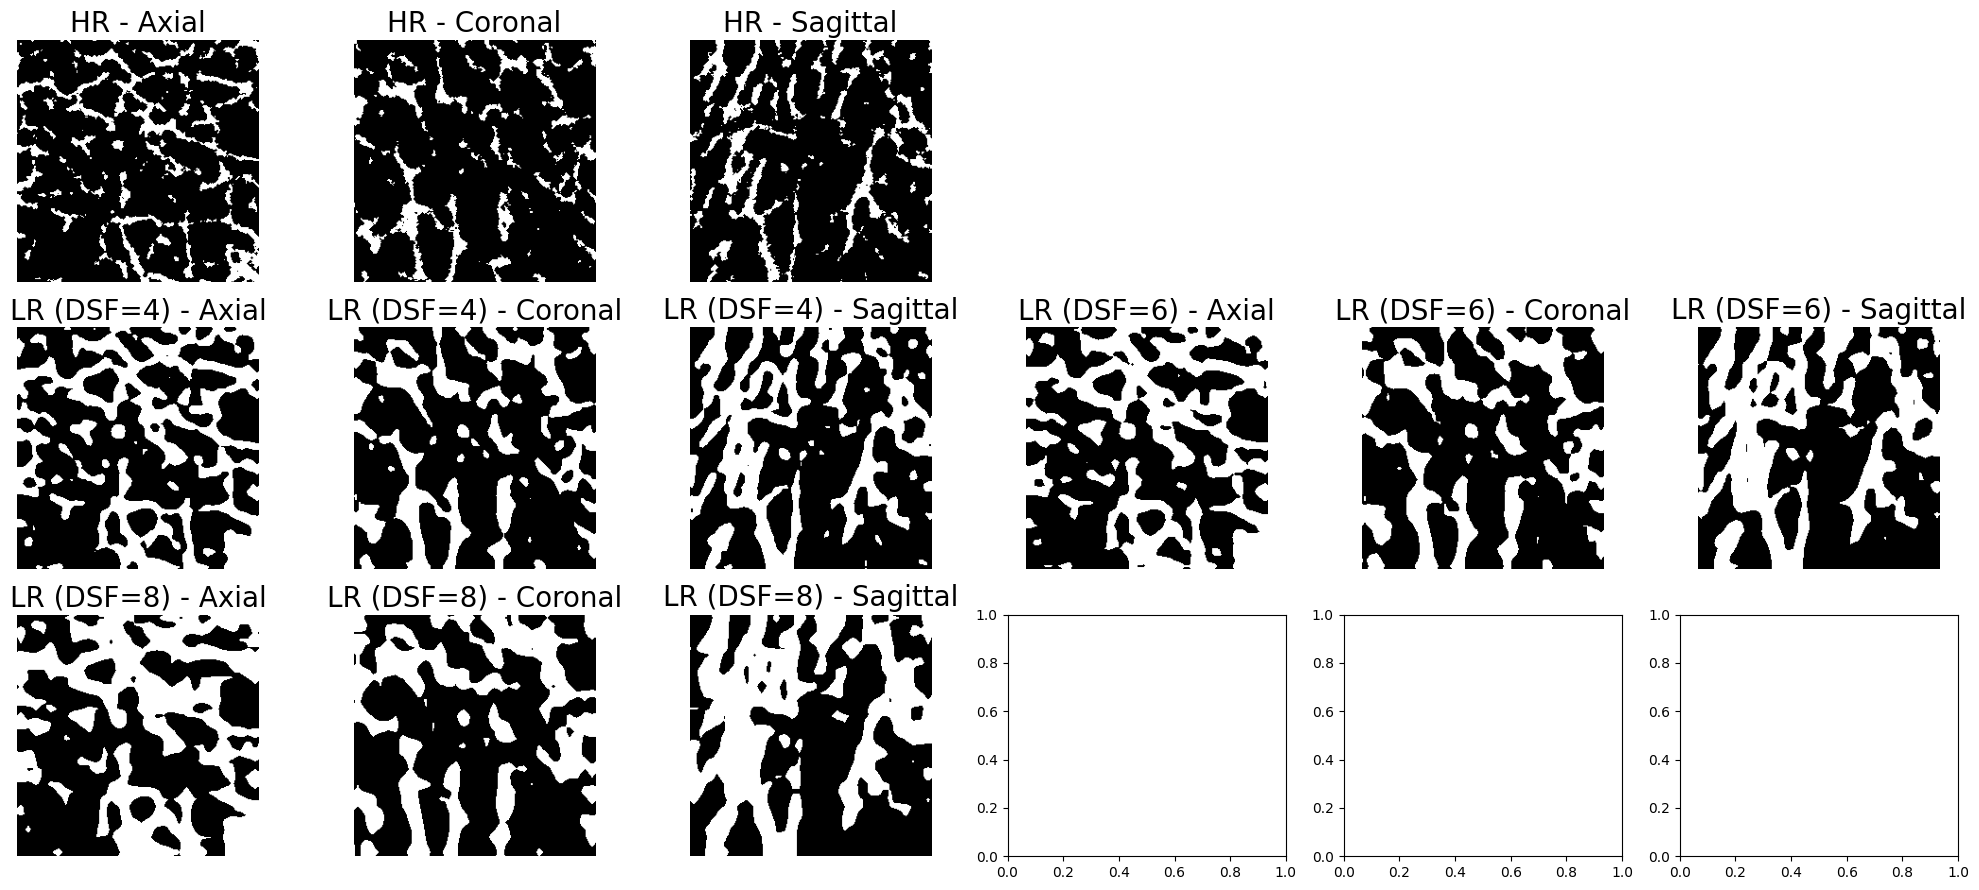

In [22]:
import torch
import matplotlib.pyplot as plt

ds_factors = [4, 6, 8, 10]  # we'll prepare for DSF=10 too
mid = patch_size // 2
slice_names = ["Axial", "Coronal", "Sagittal"]
font = 20

# --- HR mask ---
hr_tensor = torch.from_numpy(patch_hr).unsqueeze(0) / 32768.0
mask_hr = get_mask_ormir(hr_tensor)
hr_slices = [
    mask_hr[mid, :, :].numpy(),
    mask_hr[:, mid, :].numpy(),
    mask_hr[:, :, mid].numpy()
]

# --- LR masks for each DSF ---
lr_slices_dict = {}

for i, dsf in enumerate(ds_factors):
    if i >= len(patches_lr):
        print(f"⚠️ Warning: patch for DSF={dsf} not available, skipping.")
        continue

    lr_tensor = torch.from_numpy(patches_lr[i]).unsqueeze(0)
    mask_lr = get_mask_otsu(lr_tensor)

    slices = [
        mask_lr[mid, :, :].numpy(),
        mask_lr[:, mid, :].numpy(),
        mask_lr[:, :, mid].numpy()
    ]
    lr_slices_dict[dsf] = slices

# --- Plot layout ---
n_rows = 3  # HR, DSF(4+6), DSF(8+10)
n_cols = 6  # 3 views × 2 DSFs

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 9))

# --- Row 0: HR mask ---
for i, slc in enumerate(hr_slices):
    ax = axes[0, i]
    ax.imshow(slc, cmap="gray")
    ax.set_title(f"HR - {slice_names[i]}", fontsize=font)
    ax.axis("off")
    ax.set_aspect("equal", adjustable="box")

# Blank last 3 columns
for j in range(3, 6):
    axes[0, j].axis("off")

# --- Row 1: DSF=4 (left), DSF=6 (right) ---
dsf_left, dsf_right = 4, 6
if dsf_left in lr_slices_dict:
    for i, slc in enumerate(lr_slices_dict[dsf_left]):
        ax = axes[1, i]
        ax.imshow(slc, cmap="gray")
        ax.set_title(f"LR (DSF={dsf_left}) - {slice_names[i]}", fontsize=font)
        ax.axis("off")
        ax.set_aspect("equal", adjustable="box")

if dsf_right in lr_slices_dict:
    for i, slc in enumerate(lr_slices_dict[dsf_right]):
        ax = axes[1, i + 3]
        ax.imshow(slc, cmap="gray")
        ax.set_title(f"LR (DSF={dsf_right}) - {slice_names[i]}", fontsize=font)
        ax.axis("off")
        ax.set_aspect("equal", adjustable="box")

# --- Row 2: DSF=8 (left), DSF=10 (right) ---
dsf_left, dsf_right = 8, 10
if dsf_left in lr_slices_dict:
    for i, slc in enumerate(lr_slices_dict[dsf_left]):
        ax = axes[2, i]
        ax.imshow(slc, cmap="gray")
        ax.set_title(f"LR (DSF={dsf_left}) - {slice_names[i]}", fontsize=font)
        ax.axis("off")
        ax.set_aspect("equal", adjustable="box")

if dsf_right in lr_slices_dict:
    for i, slc in enumerate(lr_slices_dict[dsf_right]):
        ax = axes[2, i + 3]
        ax.imshow(slc, cmap="gray")
        ax.set_title(f"LR (DSF={dsf_right}) - {slice_names[i]}", fontsize=font)
        ax.axis("off")
        ax.set_aspect("equal", adjustable="box")

plt.tight_layout()
plt.show()


## QCT images

In [27]:
dataset_name_QCT = "registered_LR_upscaled_trimmed_split/part_2_split/part_14"


# --- Load Dask arrays ---
img_QCT = da.from_zarr(zarr_root / group_name / dataset_name_QCT)


# --- Inspect shape ---
print(f"Image shape: {img_QCT.shape}")     # Expect (N, 1, H, W)


Image shape: (177, 4608, 4608)


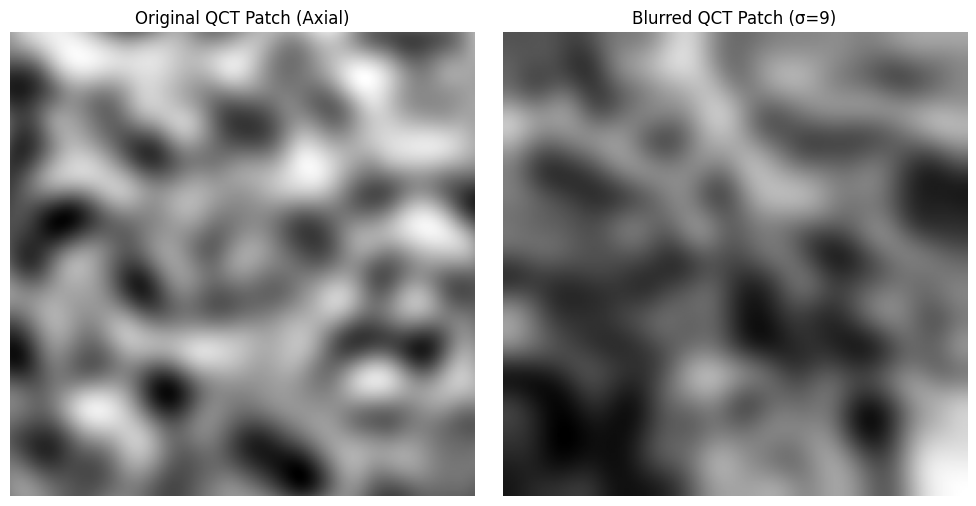

In [38]:
z, y, x = 128, 1280, 2304
patch_size = 256
half = patch_size // 2

# --- Extract and compute patch ---
patch_QCT = img_QCT[z - half:z + half, y - half:y + half, x - half:x + half].compute()

ds_10_blur = gaussian_filter(patch_lr, sigma=9)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(patch_QCT[patch_size // 2], cmap='gray')
axes[0].set_title("Original QCT Patch (Axial)")
axes[0].axis("off")

axes[1].imshow(ds_10_blur[patch_size // 2], cmap='gray')
axes[1].set_title("Blurred QCT Patch (σ=9)")
axes[1].axis("off")

plt.tight_layout()
plt.show()